In [1]:
import pandas as pd
import pandas_datareader as pdr
import numpy as np
import json
import requests
from datetime import date, datetime, timedelta

import os
from dotenv import load_dotenv
load_dotenv()

API_KEY = os.getenv('ALPHA_VANTAGE_API_KEY')

In [2]:
def get_data__alphavantage(function, symbol, api_key):
    # function = TIME_SERIES_DAILY_ADJUSTED
    # symbol = SPY
    base_url = 'https://www.alphavantage.co/query?'
    params = {
        'function': function,
        'apikey': api_key, ### get your api key at https://www.alphavantage.co/support/#api-key
        'outputsize': 'full',
        'symbol': symbol
        }
    response = requests.get(base_url, params=params)
    response_json = response.json()
    return response_json

In [3]:
def get_data__macroecon(list_symbol, column_name, stt_dt, end_dt):
    # get data from pandas_datareader for macro economics
    # https://pandas-datareader.readthedocs.io/en/latest/index.html
    # https://fred.stlouisfed.org/
    # list of monthly indicators: https://fred.stlouisfed.org/tags/series?t=monthly

    start = stt_dt
    end = end_dt
    syms = list_symbol

    df = pd.DataFrame()
    # loop through symbols and append each one to column
    for sym in syms:
        ts = pdr.fred.FredReader(sym, start=start, end=end)
        df1 = ts.read()
        df = pd.concat([df, df1], axis=1)
    # rename fields in list_symbol:column_name
    res = {list_symbol[i]: column_name[i] for i in range(len(list_symbol))}
    df = df.rename(columns=res)
    return df

In [4]:
# get SPY data
df_spy = get_data__alphavantage("TIME_SERIES_MONTHLY_ADJUSTED", "SPY", API_KEY)

# convert to df
# TIME_SERIES_DAILY_ADJUSTED = 'Time Series (Daily)'
# TIME_SERIES_MONTHLY_ADJUSTED = 'Monthly Adjusted Time Series'
df_spy = pd.DataFrame.from_dict(df_spy['Monthly Adjusted Time Series'], orient= 'index').sort_index(axis=1)

# rename columns
df_spy = (
    df_spy.rename(columns={ '1. open': 'open', '2. high': 'high', '3. low': 'low', '4. close': 'close', '5. adjusted close': 'adjclose', '6. volume': 'volume', '7. dividend amount': 'div_amt', '8. split coefficient': 'split_coeff'})
    .reset_index()
    .rename(columns={'index':'date'})
)
df_spy = df_spy[['date', 'high', 'low', 'adjclose', 'volume']]

# handle data types
cvt_dict = {
    'high': float,
    'low': float,
    'adjclose': float,
    'volume': float
    }
  
df_spy = df_spy.astype(cvt_dict)
df_spy['date'] = pd.to_datetime(df_spy['date'], format='%Y-%m-%d')
df_spy['date'] = df_spy['date'].to_numpy().astype('datetime64[M]') #use numpy conversion
df_spy = df_spy.set_index('date')

df_spy.head()


,high,low,adjclose,volume
date,,,,
2021-06-01,427.0943,414.700,426.6100,1.127058e+09
2021-05-01,422.8150,404.000,418.6518,1.527034e+09
2021-04-01,420.7200,398.180,415.9208,1.462173e+09
2021-03-01,398.1200,371.880,395.0201,2.401881e+09
2021-02-01,394.1700,370.376,377.8632,1.297510e+09


In [5]:
# get data from pandas_datareader for macro economics
# https://pandas-datareader.readthedocs.io/en/latest/index.html
# https://fred.stlouisfed.org/

# get CPI
start = datetime(2000, 1, 1)
end = datetime(2021, 12, 31)
sym = ['MEDCPIM158SFRBCLE', 'T10YIEM','UNRATE', 'T10Y2YM', 'CSUSHPINSA', 'AAA', 'BAA']
sym_col = ['cpi', '10y_be_inflation_rate','unemploy_rate_sa','10y_minus_2y_treasury','home_price_idx', 'aaa', 'baa']

df_idx = get_data__macroecon(sym, sym_col, start, end)
df_idx.head()

,cpi,10y_be_inflation_rate,unemploy_rate_sa,10y_minus_2y_treasury,home_price_idx,aaa,baa
DATE,,,,,,,
2000-01-01,3.851771,NaN,4.0,0.22,100.000,7.78,8.33
2000-02-01,2.785584,NaN,4.1,-0.09,100.571,7.68,8.29
2000-03-01,3.416809,NaN,4.0,-0.27,101.466,7.68,8.37
2000-04-01,2.276901,NaN,3.8,-0.41,102.540,7.64,8.40
2000-05-01,2.853534,NaN,4.0,-0.37,103.701,7.99,8.90


In [6]:
# Combine tables
df_ttl = df_spy.merge(df_idx, left_index=True, right_index=True)
df_ttl.describe()

,high,low,adjclose,volume,cpi,10y_be_inflation_rate,unemploy_rate_sa,10y_minus_2y_treasury,home_price_idx,aaa,baa
count,257.000000,257.000000,257.000000,2.570000e+02,257.000000,221.000000,257.000000,257.000000,255.000000,257.000000,257.000000
mean,174.907970,163.299305,145.205192,2.324847e+09,2.409139,2.037738,5.989105,1.275914,162.592906,4.843385,5.884981
std,75.602999,71.273870,81.849020,1.843773e+09,0.827192,0.405428,1.962808,0.898916,31.685417,1.303788,1.386750
min,83.300000,67.100000,56.710400,1.023655e+08,-0.286064,0.250000,3.500000,-0.410000,100.000000,2.140000,3.160000
25%,120.680000,111.870000,86.005700,1.135592e+09,1.975830,1.780000,4.600000,0.470000,141.417000,3.860000,4.770000
50%,143.810000,134.700000,107.421800,1.815146e+09,2.433336,2.120000,5.500000,1.380000,161.914000,4.970000,5.960000
75%,212.480000,203.090000,186.976900,2.967009e+09,2.932009,2.340000,7.200000,2.030000,183.433000,5.640000,6.750000
max,422.815000,404.000000,418.651800,1.188235e+10,4.621370,2.710000,14.800000,2.830000,243.658000,7.990000,9.210000


<AxesSubplot:>

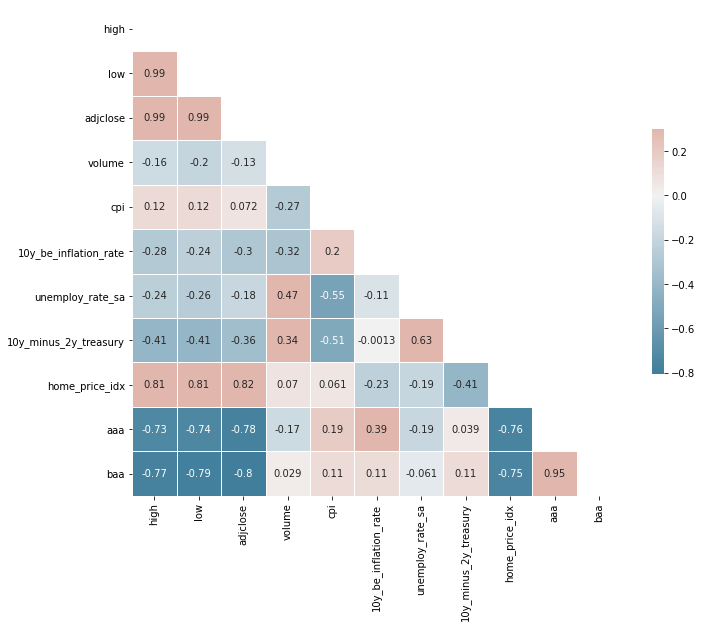

In [7]:
# Correlation

import seaborn as sns
from string import ascii_letters
import matplotlib.pyplot as plt

corr = df_ttl.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={'shrink': .5})

In [8]:

# move index to date for easier filtering
df_ttl = df_ttl.reset_index()
df_ttl = df_ttl.rename(columns={'index':'date'})
df_ttl['date'] = pd.to_datetime(df_ttl['date'], format='%Y-%m-%d')

left axis(green): adjclose ,  right axis(blue): aaa


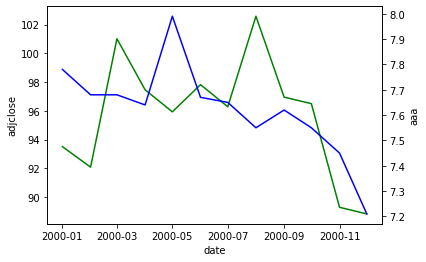

In [9]:

# set variables
dt = 'date'
fields = ['adjclose', 'aaa']
start = datetime(2000, 1, 1)
end = datetime(2000, 12, 31)

# line plot with dual axis
def plt_line_dual(df, list, date, stt, end):

    sns.lineplot(x=date, y=list[0], color = 'g',
                data=df[(df[date] >= stt) & (df[date] <= end)])
    ax2 = plt.twinx()
    sns.lineplot(x=date, y=list[1], color = 'b',
                data=df[(df[date] >= stt) & (df[date] <= end)])
    print('left axis(green):', list[0], ', ', 'right axis(blue):', list[1])

plt_line_dual(df_ttl, fields, dt, start, end)
